In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory, get_file
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from glob import glob

In [68]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [58]:
train_dir = os.path.join("data\\train", 'Open')

In [74]:
no_yawn = 'no_yawn'
no_yawn_processed = 'no_yawn_processed'

In [75]:
def preprocess(path):
    for image_path in glob(path + '/*'):
        base_name = os.path.basename(image_path)
        image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
        faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
        for (x, y, w, h) in faces:
            img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
            roi_color = img[y:y+h, x:x+w]
            cv2.imwrite(f"{os.path.join(path, base_name)}", roi_color)
   

In [ ]:
len(os.listdir(yawn_processed))

In [14]:
img_width = img_height = 224
seed = 42
batch_size = 32

train_ds = image_dataset_from_directory(train_dir,
                                        label_mode = 'int',
                                        batch_size = batch_size,
                                        image_size = (img_width, img_height),
                                        color_mode = 'rgb',
                                        labels = "inferred",
                                        shuffle = True,
                                        validation_split=0.2,
                                        subset = "training",
                                        seed = seed)

validation_ds = image_dataset_from_directory(train_dir,
                                        label_mode = 'int',
                                        batch_size = batch_size,
                                        image_size = (img_width, img_height),
                                        color_mode = 'rgb',
                                        labels = "inferred",
                                        shuffle = True,
                                        validation_split=0.2,
                                        subset = "validation",
                                        seed = seed
                                        )


Found 1452 files belonging to 2 classes.
Using 1162 files for training.
Found 1452 files belonging to 2 classes.
Using 290 files for validation.


In [15]:
class_names = train_ds.class_names
class_names

['Closed', 'Open']

In [16]:
def plot_images(images, labels, class_names):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

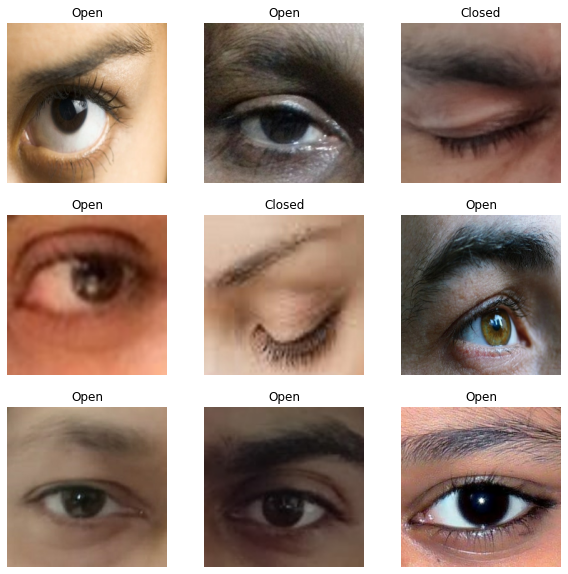

In [17]:
img_batch, label_batch = next(iter(train_ds))
plot_images(img_batch, label_batch, class_names)

In [20]:
def normalize(image, label):
    img = tf.cast(image, tf.float32)/255.0

    return img, label

In [84]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_dataset = validation_ds.skip(val_batches // 5)

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [85]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 32
Number of test batches: 6


Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(AUTOTUNE)
# test_ds = test_ds.cache().prefetch(AUTOTUNE)

### Data Augmentation

Note: These layers are active only during training, when you call Model.fit. They are inactive when the model is used in inference mode in Model.evaluate or Model.predict

In [19]:
# def augment(image, label):
#     image = tf.image.resize(image, [img_width, img_height])
#     image = tf.image.random_crop(image, [img_width, img_height, 3])
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, 0.1)
#     image = tf.image.random_saturation(image, 0.1, 2.0)
#     image = tf.image.random_hue(image, 0.1)
#     image = tf.image.random_contrast(image, 0.1, 2.0)
#     return image, label

def augment_img():
    aug = Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        # tf.keras.layers.RandomContrast(0.2)
        # tf.keras.layers.RandomTranslation(width_factor=0.2, height_factor=0.2)
    ])

    return aug

data_augmentation = augment_img()

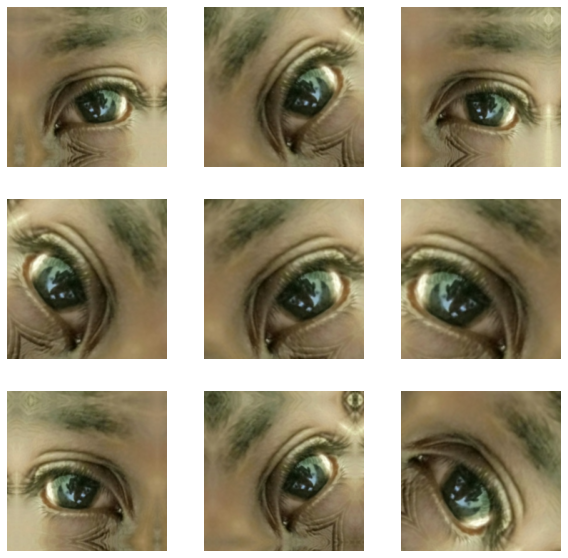

In [20]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Creating Base Model

In [21]:
base_model = MobileNetV2(input_shape=(img_width, img_height, 3),\
                        include_top=False, weights='imagenet')

base_model.trainable = False

This feature extractor converts each 244x224x3 image into a 7x7x1280 block of features. Let's see what it does to an example batch of images:

In [22]:
img_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(img_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [90]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Create Model with Fucntional API

In [23]:
img_inputs = Input(shape=(img_width, img_height, 3))
aug_img = data_augmentation(img_inputs)
preprocess_img = preprocess_input(aug_img)
b_model = base_model(preprocess_img, training=False)
global_avg_pool = GlobalAveragePooling2D()(b_model)
dropout = Dropout(0.2)(global_avg_pool)
output = Dense(1)(dropout)
model = Model(inputs=img_inputs, outputs=output)


In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
37/37 [==============================] - 65s 1s/step - loss: 0.7450 - accuracy: 0.5714 - val_loss: 0.6184 - val_accuracy: 0.5724
Epoch 2/10
37/37 [==============================] - 39s 1s/step - loss: 0.6026 - accuracy: 0.6532 - val_loss: 0.4958 - val_accuracy: 0.7207
Epoch 3/10
37/37 [==============================] - 39s 1s/step - loss: 0.5052 - accuracy: 0.7513 - val_loss: 0.4087 - val_accuracy: 0.8000
Epoch 4/10
37/37 [==============================] - 37s 1s/step - loss: 0.4378 - accuracy: 0.7788 - val_loss: 0.3423 - val_accuracy: 0.8586
Epoch 5/10
37/37 [==============================] - 39s 1s/step - loss: 0.3769 - accuracy: 0.8382 - val_loss: 0.2941 - val_accuracy: 0.8862
Epoch 6/10
37/37 [==============================] - 37s 1s/step - loss: 0.3215 - accuracy: 0.8804 - val_loss: 0.2551 - val_accuracy: 0.9172
Epoch 7/10
37/37 [==============================] - 38s 1s/step - loss: 0.2934 - accuracy: 0.8941 - val_loss: 0.2249 - val_accuracy: 0.9310
Epoch 8/10
37/37 [==

Text(0.5, 1.0, 'Training and Validation Loss')

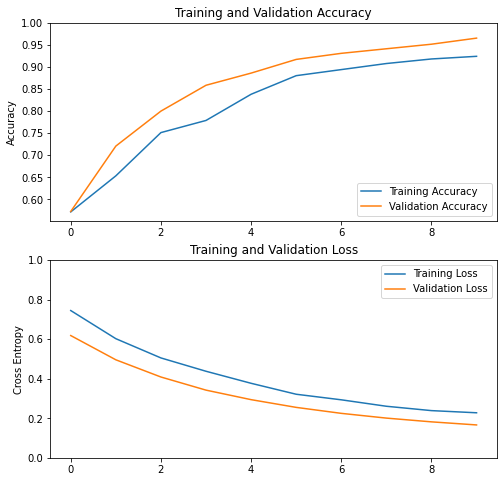

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

### Model Fine Tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.


In [28]:
# Unfreeze the top layers of the model
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


### Recompile the model 

Since we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, the model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),\
         optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), \
            metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training the model from last point

In [32]:
history_fine = model.fit(train_ds, epochs=20, \
    initial_epoch=history.epoch[-1], validation_data=validation_ds)

Epoch 10/20
37/37 [==============================] - 77s 2s/step - loss: 0.0875 - accuracy: 0.9664 - val_loss: 0.0326 - val_accuracy: 0.9931
Epoch 11/20
37/37 [==============================] - 54s 1s/step - loss: 0.0277 - accuracy: 0.9931 - val_loss: 0.0248 - val_accuracy: 0.9931
Epoch 12/20
37/37 [==============================] - 58s 2s/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0250 - val_accuracy: 0.9931
Epoch 13/20
37/37 [==============================] - 61s 2s/step - loss: 0.0134 - accuracy: 0.9948 - val_loss: 0.0310 - val_accuracy: 0.9931
Epoch 14/20
37/37 [==============================] - 55s 1s/step - loss: 0.0113 - accuracy: 0.9957 - val_loss: 0.0160 - val_accuracy: 0.9931
Epoch 15/20
37/37 [==============================] - 58s 2s/step - loss: 0.0069 - accuracy: 0.9966 - val_loss: 0.0182 - val_accuracy: 0.9931
Epoch 16/20
37/37 [==============================] - 54s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9931
Epoch 17/20
3

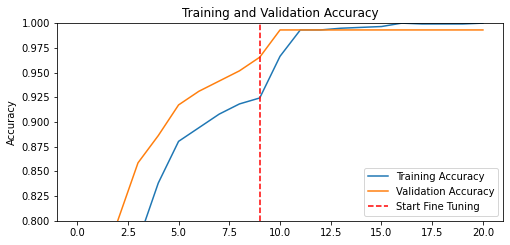

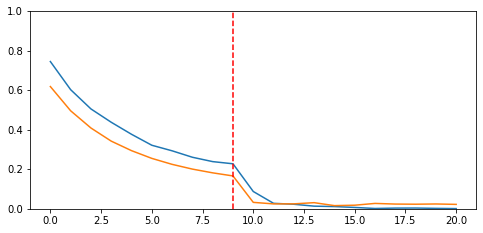

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8,1])
plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), color='red', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), color='red', linestyle='--', label='Start Fine Tuning')

In [35]:
loss, accuracy = model.evaluate(validation_ds)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

10/10 [==============================] - 6s 640ms/step - loss: 0.0224 - accuracy: 0.9931
Test Loss: 0.022361131384968758, Test Accuracy: 0.9931034445762634


In [37]:
image_batch, label_batch = next(iter(validation_ds))
predictions = model.predict_on_batch(image_batch).flatten()

In [38]:
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions > 0.5, 1, 0)
print(f"predictions: {predictions.numpy()}, \nlabels: {label_batch}")

predictions: [0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1], 
labels: [0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1]


In [39]:
def plot_images(images, labels, preds, class_names):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if class_names[labels[i]] == class_names[preds[i]]:
        plt.title(class_names[preds[i]], color='green')
    else:
        plt.title(class_names[preds[i]], color='red')
    plt.axis("off")

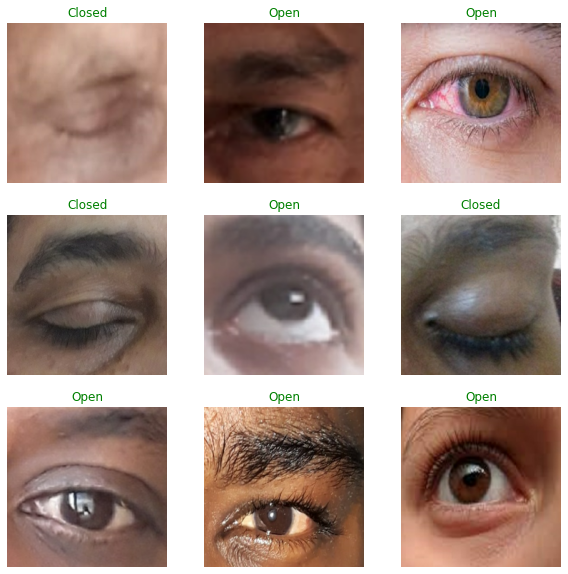

In [40]:
plot_images(image_batch, label_batch, predictions, class_names)